# Feature Pruning Experiment
This notebook evaluates which features can be dropped without significant loss for Random Forest and HMM.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load processed feature set
df_feat = pd.read_pickle('df_feat.pkl')
target_col = 'mood_cat'
exclude_cols = ['nextday', 'mood_cat']
feature_cols = [c for c in df_feat.columns if c not in exclude_cols]
X = df_feat[feature_cols]
y = df_feat[target_col]
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [3]:
# Scale features for HMM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
# Baseline Random Forest accuracy
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
baseline_rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Baseline RF accuracy: {baseline_rf_acc:.3f}")


Baseline RF accuracy: 0.483


In [5]:
# Baseline HMM accuracy
models = {}
for label in np.unique(y_train):
    m = GaussianHMM(n_components=1, covariance_type='full', n_iter=100, random_state=42)
    m.fit(X_train_scaled[y_train == label])
    models[label] = m

def predict_hmm(models, X):
    preds = []
    for obs in X:
        scores = {lbl: mdl.score(obs.reshape(1, -1)) for lbl, mdl in models.items()}
        preds.append(max(scores, key=scores.get))
    return np.array(preds)

y_pred_hmm = predict_hmm(models, X_test_scaled)
baseline_hmm_acc = accuracy_score(y_test, y_pred_hmm)
print(f"Baseline HMM accuracy: {baseline_hmm_acc:.3f}")

print("RF Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("HMM Classification Report:")
print(classification_report(y_test, y_pred_hmm))


c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

Baseline HMM accuracy: 0.400
RF Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        32
           1       0.41      0.61      0.49        44
           2       0.33      0.21      0.26        14
           3       0.45      0.33      0.38        30
           4       0.60      0.48      0.53        25

    accuracy                           0.48       145
   macro avg       0.49      0.44      0.45       145
weighted avg       0.50      0.48      0.48       145

HMM Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.62      0.56        32
           1       0.38      0.23      0.29        44
           2       0.23      0.64      0.34        14
           3       0.48      0.33      0.39        30
           4       0.45      0.36      0.40        25

    accuracy                           0.40       145
   macro avg       0.41      0.44      0.40      

In [6]:
# Define evaluation functions for feature subsets
def eval_rf(feats):
    m = RandomForestClassifier(n_estimators=100, random_state=42)
    m.fit(X_train[feats], y_train)
    return accuracy_score(y_test, m.predict(X_test[feats]))

def eval_hmm(feats):
    scaler_sub = StandardScaler()
    X_tr = scaler_sub.fit_transform(X_train[feats])
    X_te = scaler_sub.transform(X_test[feats])
    mods = {}
    for lbl in np.unique(y_train):
        hm = GaussianHMM(n_components=1, covariance_type='full', n_iter=100, random_state=42)
        hm.fit(X_tr[y_train == lbl])
        mods[lbl] = hm
    y_pr = predict_hmm(mods, X_te)
    return accuracy_score(y_test, y_pr)


In [7]:
# Evaluate impact of dropping each feature
results = []
for f in feature_cols:
    feats = [c for c in feature_cols if c != f]
    rf_acc = eval_rf(feats)
    hmm_acc = eval_hmm(feats)
    results.append({'feature': f, 'rf_acc': rf_acc, 'hmm_acc': hmm_acc})

results_df = pd.DataFrame(results)
results_df['rf_delta'] = baseline_rf_acc - results_df['rf_acc']
results_df['hmm_delta'] = baseline_hmm_acc - results_df['hmm_acc']
results_df = results_df.sort_values('rf_delta')
results_df.head(10)

c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

,feature,rf_acc,hmm_acc,rf_delta,hmm_delta
19,screen_log,0.475862,0.413793,0.006897,-0.013793
11,appCat.utilities,0.468966,0.413793,0.013793,-0.013793
2,appCat.communication,0.462069,0.400000,0.020690,0.000000
4,appCat.finance,0.462069,0.413793,0.020690,-0.013793
15,circumplex.valence,0.462069,0.406897,0.020690,-0.006897
9,appCat.travel,0.462069,0.393103,0.020690,0.006897
12,appCat.weather,0.462069,0.400000,0.020690,0.000000
10,appCat.unknown,0.455172,0.400000,0.027586,0.000000
3,appCat.entertainment,0.455172,0.400000,0.027586,0.000000
14,circumplex.arousal,0.455172,0.393103,0.027586,0.006897


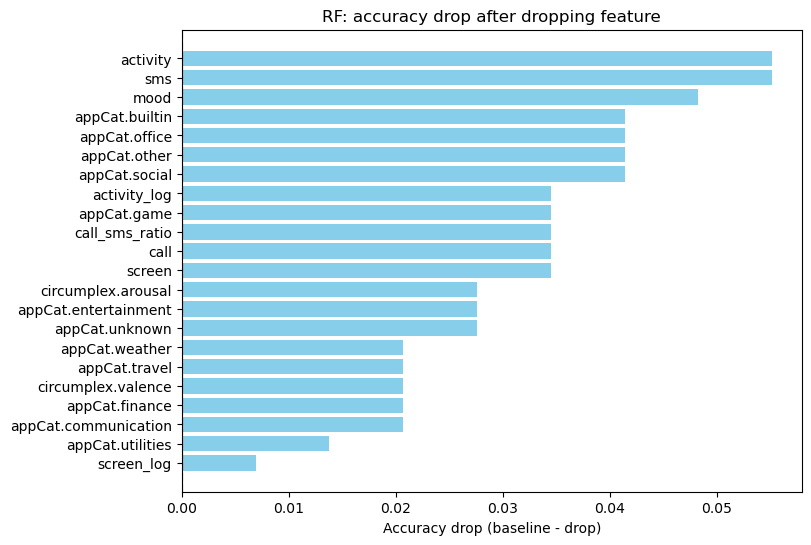

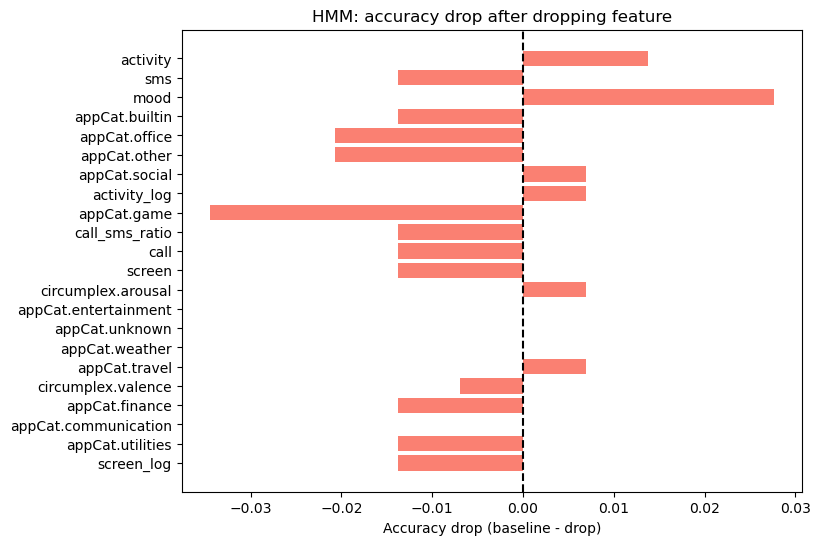

In [8]:
# Plot feature-impact deltas
plt.figure(figsize=(8,6))
plt.barh(results_df['feature'], results_df['rf_delta'], color='skyblue')
plt.axvline(0, color='k', linestyle='--')
plt.title('RF: accuracy drop after dropping feature')
plt.xlabel('Accuracy drop (baseline - drop)')
plt.show()

plt.figure(figsize=(8,6))
plt.barh(results_df['feature'], results_df['hmm_delta'], color='salmon')
plt.axvline(0, color='k', linestyle='--')
plt.title('HMM: accuracy drop after dropping feature')
plt.xlabel('Accuracy drop (baseline - drop)')
plt.show()
